In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import   OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_sin_movilidad_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_sin_movilidad_20_21.csv", sep = ";")

In [ ]:
df_sin_movilidad_20_21.head()

,fecha,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,...,alto_riesgo,peligro,vulner,ocurrencia,municipio,cod_municipio,laborable,dayofyear,weekend,mes
0,2015-01-01,0002I,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,...,Sí,Molt Alt,Molt Alta,0,Vandellos l’Hospitalet de l’Infant,43162,3,1,0,1
1,2015-01-01,WE,0.0,11.3,11.1,10.7,5.3,7.8,449.0,1027.2,...,Sí,Alt,Molt Alta,0,Vilanova del Vallès,8946,3,1,0,1
2,2015-01-01,WG,0.0,8.5,8.1,7.6,0.8,2.3,428.0,1020.0,...,Sí,Molt Alt,Moderada,0,Algerri,25528,3,1,0,1
3,2015-01-01,WI,0.0,7.8,7.6,7.4,2.1,4.1,468.0,1031.5,...,Sí,Molt Alt,Baixa,0,Maials,25761,3,1,0,1
4,2015-01-01,WJ,0.0,12.3,11.7,11.3,1.0,2.4,449.0,1000.2,...,Sí,Molt Alt,Moderada,0,El Masroig,43675,3,1,0,1


In [ ]:
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.sort_values(by='fecha')
df_sin_movilidad_20_21.set_index('fecha', inplace=True)

In [ ]:
df_sin_movilidad_20_21.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'laborable', 'dayofyear',
       'weekend', 'mes'],
      dtype='object')

In [ ]:
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.drop(['indicativo', 'municipio', 'cod_municipio'], axis=1)
df_sin_movilidad_20_21.head()

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,ocurrencia,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,1020.1,63.0,281.0,2.50,Sí,Molt Alt,Molt Alta,0,3,1,0,1
2015-01-01,0.0,12.0,11.6,10.8,0.8,1.8,437.0,1034.6,1034.4,55.0,174.0,2.50,Sí,Molt Alt,Moderada,0,3,1,0,1
2015-01-01,0.0,13.5,6.2,-1.1,1.9,7.2,7.3,1027.2,1021.7,63.0,117.0,2.50,Sí,Exclos,Moderada,0,3,1,0,1
2015-01-01,0.0,11.7,4.2,-3.3,1.1,6.1,7.4,1001.5,996.5,60.0,277.0,3.22,Sí,Alt,Mitja,0,3,1,0,1
2015-01-01,0.0,14.2,10.3,6.4,2.5,13.3,429.0,1034.6,1034.4,68.0,615.0,5.10,Sí,Molt Alt,Moderada,0,3,1,0,1


In [ ]:
df_sin_movilidad_20_21.shape

(488345, 20)

In [ ]:
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.loc['2020-02-21':'2021-05-09'] 

In [ ]:
df_sin_movilidad_20_21.groupby("ocurrencia").count()

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382


##Model xgboost

In [ ]:
df_sin_movilidad_20_21.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha', 'sol', 'presMax',
       'presMin', 'rhum', 'altitud', 'porcentaje_pendiente_total',
       'alto_riesgo', 'peligro', 'vulner', 'laborable', 'dayofyear', 'weekend',
       'mes'],
      dtype='object')

In [ ]:
df_ocurrencia_0 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==0].sample(382)

In [ ]:
df_ocurrencia_1 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==1]

In [ ]:
df_sin_movilidad_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad_20_21.shape

(764, 20)

In [ ]:
X = df_sin_movilidad_20_21.drop( ['ocurrencia'], axis=1)
y = df_sin_movilidad_20_21['ocurrencia']

In [ ]:
# Utilizando random para genera números aleatorios.
import random
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
df_sin_movilidad_20_21.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((764, 20), (611, 19), (611,), (153, 19), (153,))

In [ ]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec","tmed","velmedia","sol","presMax","rhum", "altitud", "porcentaje_pendiente_total"]]
numericalCols_test = X_test[["prec","tmed","velmedia","sol","presMax","rhum", "altitud", "porcentaje_pendiente_total"]]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 8), (153, 8))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['alto_riesgo',	'peligro',	'vulner',]]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 12), (153, 12))

In [ ]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [ ]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 24), (611,), (153, 24), (153,))

In [ ]:
X_test = df_test_scaled
X_train = df_train_scaled

In [ ]:
from pandas.core.common import random_state
model = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6143790849673203

Conjunto de datos de validación
  Exactitud:     0.61438
  Precisión:     0.61432
  Exhaustividad: 0.61436
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        75
           1       0.62      0.62      0.62        78

    accuracy                           0.61       153
   macro avg       0.61      0.61      0.61       153
weighted avg       0.61      0.61      0.61       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


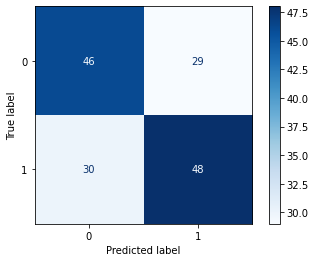

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')


print(classification_report(y_test, y_pred))

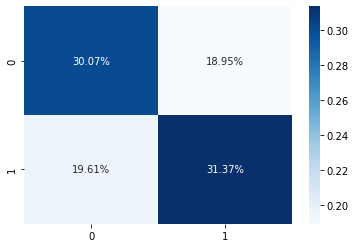

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

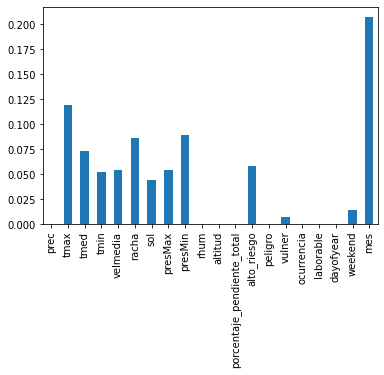

In [ ]:
importances = model.feature_importances_
importances_dict = dict(zip(df_sin_movilidad_20_21.columns, importances))
pd.Series(importances_dict).plot(kind='bar')

#Grid Model XGBoost

In [ ]:
param_grid = {
    'n_estimators': [1500],
    'max_depth' : [5, 10],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 50}]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}],
                         'max_depth': [5, 10], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10], 'n_estimators': [1500]},
             verbose=True)

In [ ]:
final_model = grid_search.best_estimator_
final_model

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.62092
  Precisión:     0.62154
  Exhaustividad: 0.62191
              precision    recall  f1-score   support

           0       0.59      0.64      0.61        72
           1       0.65      0.60      0.63        81

    accuracy                           0.62       153
   macro avg       0.62      0.62      0.62       153
weighted avg       0.62      0.62      0.62       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


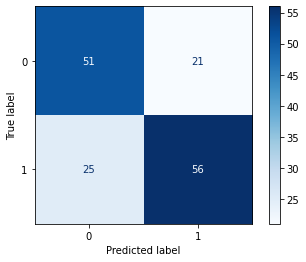

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

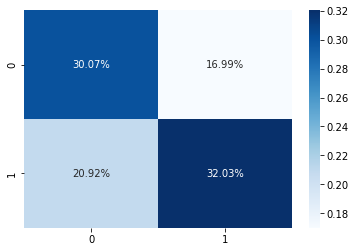

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

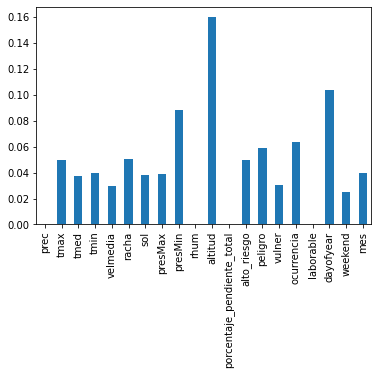

In [ ]:
importances_final = final_model.feature_importances_
importances_dict_final = dict(zip(df_sin_movilidad_20_21.columns, importances_final))
pd.Series(importances_dict_final).plot(kind='bar')

#Balanceo de clases con SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample(X_train, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 301
Before OverSampling, counts of label '0': 310 

After OverSampling, the shape of train_X: (620, 24)
After OverSampling, the shape of train_y: (620,) 

After OverSampling, counts of label '1': 310
After OverSampling, counts of label '0': 310


In [ ]:
model_smote = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [ ]:
model_smote.fit(X_smote, y_smote)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [ ]:
y_pred_smote = model_smote.predict(X_test)

In [ ]:
y_test.sum(), y_pred_smote.sum()

(81, 66)

Conjunto de datos de validación
  Exactitud:     0.62092
  Precisión:     0.62154
  Exhaustividad: 0.62191
              precision    recall  f1-score   support

           0       0.59      0.64      0.61        72
           1       0.65      0.60      0.63        81

    accuracy                           0.62       153
   macro avg       0.62      0.62      0.62       153
weighted avg       0.62      0.62      0.62       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


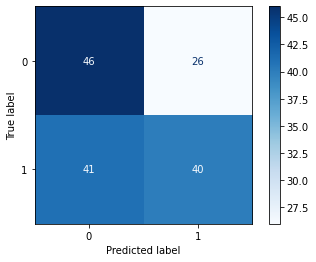

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_smote, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

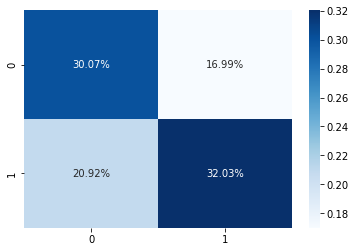

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

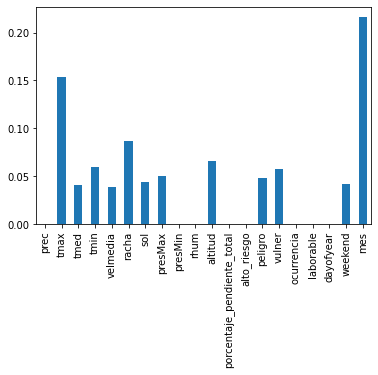

In [ ]:
importances_smote = model_smote.feature_importances_
importances_dict_smote = dict(zip(df_sin_movilidad_20_21.columns, importances_smote))
pd.Series(importances_dict).plot(kind='bar')

#Grid Smote

In [ ]:
param_grid = {
    'n_estimators': [1500,2500],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [5, 10, 15],
    'min_samples_leaf' : [5, 10, 15],
    'class_weight':[{0: 1, 1: 1}]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, verbose=True)
grid_search.fit(X_smote, y_smote)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [1500, 2500]},
             verbose=True)

In [ ]:
final_model_smote = grid_search.best_estimator_
final_model_smote

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.96732
  Precisión:     0.96728
  Exhaustividad: 0.96744
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.97      0.96      0.97        78

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


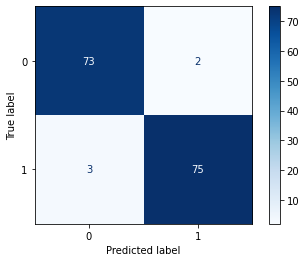

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
y_pred = final_model_smote.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model_smote, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

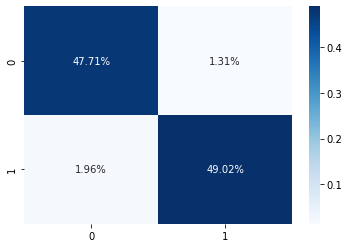

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

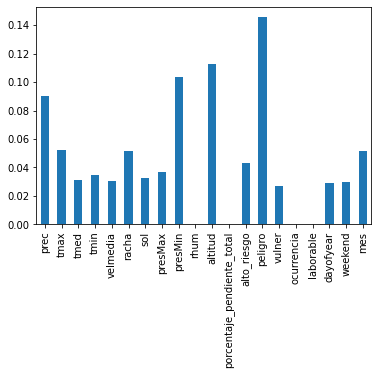

In [ ]:
importances_smote_final = final_model_smote.feature_importances_
importances_dict_final_smote = dict(zip(df_sin_movilidad_20_21.columns, importances_smote_final))
pd.Series(importances_dict_final_smote).plot(kind='bar')

#Balanceo de clases RandomUnderSampler


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(X_train, y_train)


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before OverSampling, counts of label '1': 301
Before OverSampling, counts of label '0': 310 

After OverSampling, the shape of train_X: (602, 24)
After OverSampling, the shape of train_y: (602,) 

After OverSampling, counts of label '1': 301
After OverSampling, counts of label '0': 301


In [ ]:
model_rus = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [ ]:
model_rus.fit(X_rus, y_rus)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [ ]:
y_pred = model_rus.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Conjunto de datos de validación
  Exactitud:     0.57516
  Precisión:     0.57343
  Exhaustividad: 0.57330
              precision    recall  f1-score   support

           0       0.55      0.54      0.55        72
           1       0.60      0.60      0.60        81

    accuracy                           0.58       153
   macro avg       0.57      0.57      0.57       153
weighted avg       0.57      0.58      0.57       153



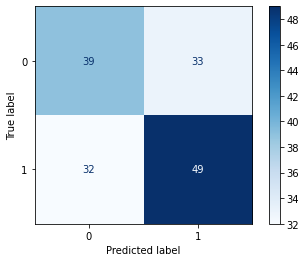

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_rus, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

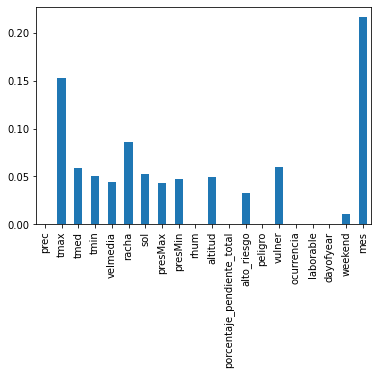

In [ ]:
importances_rus = model_rus.feature_importances_
importances_dict_rus = dict(zip(df_sin_movilidad_20_21.columns, importances_rus))
pd.Series(importances_dict_rus).plot(kind='bar')

#Grid Rus

In [ ]:
param_grid = {
    'n_estimators': [1500,2500],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [5, 10,15],
    'min_samples_leaf' : [5, 10,15],
    'class_weight':[{0: 1, 1: 1}]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_rus, y_rus)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [1500, 2500]},
             verbose=True)

In [ ]:
final_model_rus = grid_search.best_estimator_
final_model_rus

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.71242
  Precisión:     0.71142
  Exhaustividad: 0.71142
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        72
           1       0.73      0.73      0.73        81

    accuracy                           0.71       153
   macro avg       0.71      0.71      0.71       153
weighted avg       0.71      0.71      0.71       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


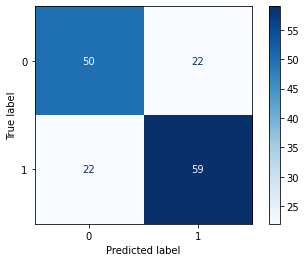

In [ ]:
y_pred = final_model_rus.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model_rus, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

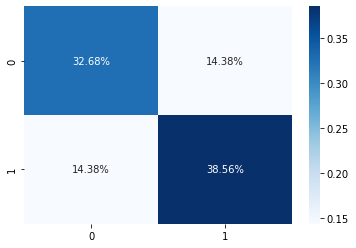

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

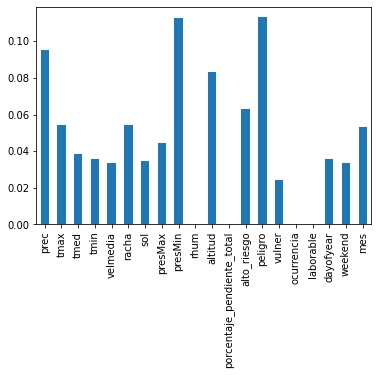

In [ ]:
importances_final_rus = final_model_rus.feature_importances_
importances_dict_final_rus = dict(zip(df_sin_movilidad_20_21.columns, importances_final_rus))
pd.Series(importances_dict_final_rus).plot(kind='bar')

#Seleccion de variables importantes


In [ ]:
df_sin_movilidad_import = df_sin_movilidad_20_21.drop(['tmax', 'tmin', 'sol', 'velmedia','presMax','rhum', 'porcentaje_pendiente_total', 'weekend','laborable','alto_riesgo', ], axis=1)
df_sin_movilidad_import

,prec,tmed,racha,presMin,altitud,peligro,vulner,ocurrencia,dayofyear,mes
fecha,,,,,,,,,,
2020-02-21,0.0,10.1,6.1,1029.8,556.0,Exclos,Moderada,0,52,2
2020-08-22,0.0,29.9,13.4,995.9,28.0,Molt Alt,Molt Alta,0,235,8
2020-04-25,0.0,22.0,7.9,1003.5,552.0,Alt,Moderada,0,116,4
2020-08-15,0.0,26.2,8.3,999.7,143.0,Exclos,Molt Alta,0,228,8
2021-01-29,0.0,18.1,9.4,975.4,463.0,Molt Alt,Moderada,0,29,1
...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,27.4,4.8,1016.0,381.0,Molt Alt,Moderada,1,128,5
2021-05-08,0.0,25.2,7.1,1012.8,397.0,Molt Alt,Baixa,1,128,5
2021-05-08,0.0,24.8,8.6,1003.1,145.0,Exclos,Molt Alta,1,128,5


In [ ]:
df_sin_movilidad_import.groupby("ocurrencia").count()

,prec,tmed,racha,presMin,altitud,peligro,vulner,dayofyear,mes
ocurrencia,,,,,,,,,
0,382,382,382,382,382,382,382,382,382
1,382,382,382,382,382,382,382,382,382


In [ ]:
df_sin_movilidad_import.groupby("ocurrencia").count().columns

Index(['prec', 'tmed', 'racha', 'presMin', 'altitud', 'peligro', 'vulner',
       'dayofyear', 'mes'],
      dtype='object')

In [ ]:
df_ocurrencia_0 = df_sin_movilidad_import[df_sin_movilidad_import["ocurrencia"]==0].sample(382)

In [ ]:
df_ocurrencia_1 = df_sin_movilidad_import[df_sin_movilidad_import["ocurrencia"]==1]

In [ ]:
df_sin_movilidad_import =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad_import.shape
df_sin_movilidad_import

,prec,tmed,racha,presMin,altitud,peligro,vulner,ocurrencia,dayofyear,mes
fecha,,,,,,,,,,
2020-03-31,0.0,12.5,5.3,993.0,480.0,Alt,Molt Alta,0,91,3
2021-02-15,0.0,10.9,3.3,1028.7,31.0,Molt Alt,Moderada,0,46,2
2020-11-16,0.0,18.1,6.4,957.6,487.0,Molt Alt,Moderada,0,321,11
2020-09-27,0.0,20.2,9.4,1010.3,125.0,Exclos,Moderada,0,271,9
2020-09-20,0.0,21.7,4.1,1014.6,881.0,Moderat,Moderada,0,264,9
...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,27.4,4.8,1016.0,381.0,Molt Alt,Moderada,1,128,5
2021-05-08,0.0,25.2,7.1,1012.8,397.0,Molt Alt,Baixa,1,128,5
2021-05-08,0.0,24.8,8.6,1003.1,145.0,Exclos,Molt Alta,1,128,5


In [ ]:
X = df_sin_movilidad_import.drop( ['ocurrencia'], axis=1)
y = df_sin_movilidad_import['ocurrencia']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
df_sin_movilidad_import.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((764, 10), (611, 9), (611,), (153, 9), (153,))

In [ ]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["tmed", "racha", "altitud","prec", 'presMin']]
numericalCols_test = X_test[["tmed", "racha", "altitud", "prec", 'presMin']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 5), (153, 5))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[[	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['vulner']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 5), (153, 5))

In [ ]:
Other_var_train = X_train[[	'mes', 'dayofyear']]
Other_var_test = X_test[[	'mes', 'dayofyear']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [ ]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 12), (611,), (153, 12), (153,))

In [ ]:
X_test = df_test_scaled
X_train = df_train_scaled

In [ ]:
model_importances = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [ ]:
model_importances.fit(X_train, y_train)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [ ]:
y_pred = model_importances.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6013071895424836

Conjunto de datos de validación
  Exactitud:     0.60131
  Precisión:     0.59687
  Exhaustividad: 0.59822
              precision    recall  f1-score   support

           0       0.66      0.62      0.64        87
           1       0.54      0.58      0.55        66

    accuracy                           0.60       153
   macro avg       0.60      0.60      0.60       153
weighted avg       0.61      0.60      0.60       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


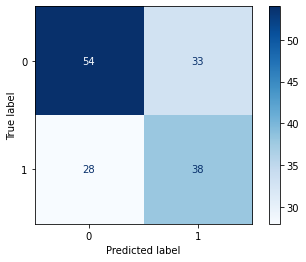

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_importances, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

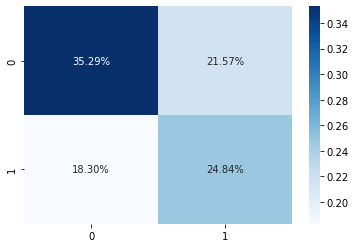

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

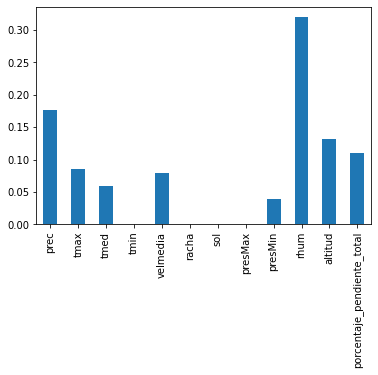

In [ ]:
importances_model = model_importances.feature_importances_
importances_dict_import = dict(zip(df_sin_movilidad_import.columns, importances_model))
pd.Series(importances_dict_import).plot(kind='bar')